In [18]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Albumentations is a Python library for image augmentation.
import albumentations as A 

# The import requests statement in Python is used to bring the requests library into a script, 
# making its functionalities available for use. 
# The requests library is a popular and user-friendly library for making HTTP requests in Python, 
# simplifying interactions with web services and API
import requests

from io import BytesIO

from PIL import Image
import random
import torch
from tqdm.notebook import tqdm

import torch.nn as nn #neural networks in pytorch
from torch._C import device # 2 types of devices - CPU/GPU. To manage devices.
import torch.optim as optim # optimizer like SGD/adam in tensorflow
import torch.autograd.grad_mode as grad_mode #automatic gradient calculations
from torch.autograd import Function as F # Base class in PyTorch for implementing custom autograd operations
from torch.utils.data import Dataset, DataLoader # To load data more efficiently wrt pytorch

import torchvision #computer vision package in pytorch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection import fasterrcnn_resnet50_fpn #feature pyramid network
from torchvision.models.detection.rpn import AnchorGenerator


In [19]:
# If GPU is available, use it, else use CPU

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

device

device(type='cuda')

In [20]:
# Display the image with the bounding boxes for each object/gun in the image

def imgshow(number, title=None, size=5):
    root = "/kaggle/input/guns-object-detection/" #directory where the dataset is located
    image = cv2.imread(root + "Images/" + str(number) + ".jpeg") #display the image

    file = open(root + "Labels/" + str(number) + ".txt", 'r') #corresponding file name
    txt_data = file.readlines()
    file.close()

    # Loop into each bounding box in the label file
    # Label file has number(number of objects/guns in image) and the 4 measurements of the bounding box for each object/gun
    for  i in range(0,int(txt_data[0])):
        indices = [int(x) for x in txt_data[i+1].split()] #to store the coordinates x1/y1, x2/y2
        start_point = (indices[0], indices[1]) # x1,y1
        end_point = (indices[2], indices[3])   # x2,y2

        cv2.rectangle(image,start_point, end_point, (0,0,255), 2)

    aspect_ratio = image.shape[0] / image.shape[1] # adjusting height and width of image for display size 0 is h and 1 is w

    plt.figure(figsize=(size+aspect_ratio,size)) # Ensuring original image & processed image have same size

    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB)) #cv2 is BGR and plt.imshow is RGB so converting
    plt.title(title+txt_data[0])
    plt.show()      

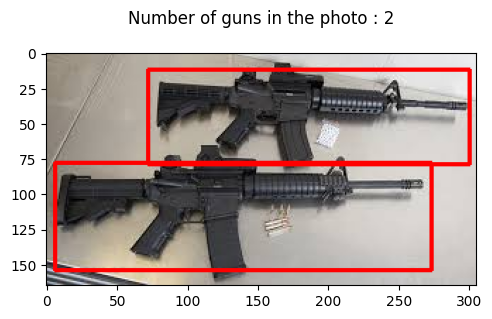

In [21]:
imgshow(119,title="Number of guns in the photo : ")

In [22]:
import os

In [23]:
# Custom dataset class for loading data and processing the images before sending to the model

class Gun_Data(Dataset):
    def __init__(self,root):
        self.image_path = root+"Images/"
        self.labels_path = root+"Labels/"

        self.img_name = [img for img in sorted(os.listdir(self.image_path))]
        self.label_name = [label for label in sorted(os.listdir(self.labels_path))]

# Fetch the image and its corresponding label, using the index idx
    def __getitem__(self,idx):
        image_path = os.path.join(self.image_path, str(self.img_name[idx]))
        image = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
 
        img_res = img_rgb/255                             # Scaling (Normalizing)
        img_res = torch.as_tensor(img_res).permute(2,0,1) # Convert to pytorch tensor ; (2,0,1) is shape of tensor

        label_name = self.img_name[idx][:-4] + "txt"  # Remove "jpeg" from ".jpeg" and then add ".txt"
        label_path = os.path.join(self.labels_path, str(label_name))

        with open(label_path, 'r') as label_file:
            l_count = int(label_file.readline()) # Reads first line to get count of objects
            box=[]
            for i in range(l_count):
                box.append(list(map(int,label_file.readline().split()))) #int is the function here


        target={}     # stores the target info 
        area=[]       # stores areas of bounding box
        labels=[]     # labels for each bounding box


        for i in range(len(box)):
            a = (box[i][2] - box[i][0]) * (box[i][3] - box[i][1]) # (x2-x1)*(y2-y1)
            area.append(a)

        for i in range(len(box)):
            labels.append(1)  # Same label for all the objects

        target["boxes"] = torch.as_tensor(box)
        target["area"] = torch.as_tensor(area)
        target["image_id"] = torch.as_tensor([idx])
        target["labels"] = torch.as_tensor(labels, dtype=torch.int64)

        img_res = img_res.to(device)                  # Move image tensor to the correct device (cuda)
        for key in target:                            # Move target elements/tensors to the correct device (cuda)
            if isinstance(target[key], torch.Tensor):
                target[key] = target[key].to(device)
                
        return img_res, target

    def __len__(self):
            return len(self.img_name)    # Returns the total number of images in the dataset
            

In [24]:
# Model Training to handle the fasterrcnn model

class Model:
    def __init__(self,num):
        self.num = num                    # number of classes in object detection Ex: cats and dogs
        self.model = self.create_model()


    def create_model(self):
        model = fasterrcnn_resnet50_fpn(pretrained=True) # Picking pretrained fasterrcnn model pre-trained on resent50

        in_features = model.roi_heads.box_predictor.cls_score.in_features # Get number of I/P features of pre-trained model

        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, self.num) #Replacing with # of features in our case

        return model

    def compiler(self, optimizer):
        self.optimizer = optimizer

    def train(self, train_data, val_data):
        for epoch in tqdm(range(num_epoch)):
            self.model = self.model.to(device)  #Moving model to device

            train_loss=0
            self.model.train()

            for img, target in train_data:
                loss_dic = self.model(img,target)      # calculate loss in forward pass
                loss = sum(loss for loss in loss_dic.values()) # calculate sum of all loss values

                self.optimizer.zero_grad() # zero out all gradients
                loss.backward()            # calculate gradients backward propagation

                self.optimizer.step()     # use optimizer to update model weights
                train_loss += loss        # Overall train loss

            print(f'Epoch : {epoch+1} | Train loss : {train_loss}')

In [25]:
from torch.utils.data import random_split

In [26]:

# Train the Model

rcnn = Model(2) # 2 classes - one for gun and one for background

model = rcnn.model

optimizer = optim.Adam(model.parameters(), lr=0.0001)

num_epoch = 30

rcnn.compiler(optimizer)

def collate_fn(batch):
    return tuple(zip(*batch)) # Tuple up all the data and target tensors from the batch

dataset=Gun_Data("/kaggle/input/guns-object-detection/")

train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=True, num_workers=0, collate_fn=collate_fn)



In [27]:
# Execute training the model

rcnn.train(train_loader, val_loader)

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch : 1 | Train loss : 20.657629013061523
Epoch : 2 | Train loss : 16.488265991210938
Epoch : 3 | Train loss : 14.631192207336426
Epoch : 4 | Train loss : 11.72735595703125
Epoch : 5 | Train loss : 11.319501876831055
Epoch : 6 | Train loss : 9.858640670776367
Epoch : 7 | Train loss : 8.439743041992188
Epoch : 8 | Train loss : 7.547360420227051
Epoch : 9 | Train loss : 7.244506359100342
Epoch : 10 | Train loss : 6.5940165519714355
Epoch : 11 | Train loss : 6.269041061401367
Epoch : 12 | Train loss : 5.756070613861084
Epoch : 13 | Train loss : 5.661539077758789
Epoch : 14 | Train loss : 5.189243793487549
Epoch : 15 | Train loss : 5.173243045806885
Epoch : 16 | Train loss : 5.098776817321777
Epoch : 17 | Train loss : 5.2585296630859375
Epoch : 18 | Train loss : 4.469664573669434
Epoch : 19 | Train loss : 3.9430696964263916
Epoch : 20 | Train loss : 3.9947261810302734
Epoch : 21 | Train loss : 4.104559421539307
Epoch : 22 | Train loss : 3.916139841079712
Epoch : 23 | Train loss : 3.75803

In [30]:
# Test Predictions
# 334 images in dataset

def test(data, number=random.randint(1,334)): # Get specified image and it's corresponding target
    img, target = data[number]
    model.eval()                              # Disables batch normalization and dropout layers

    predictions = model([img])

    predictions = [{k:v.to(device) for k,v in t.items()} for t in predictions] # Move predictions to device cuda

    return predictions, target, img

In [31]:
# Non-maximum supression
# iou is metrics for object detection like for regression & classification

def apply_nms(orig_predictions, iou_threshold=None):
    keep = torchvision.ops.nms(orig_predictions["boxes"],orig_predictions["scores"], iou_threshold) #indexes of boxes

    final_predictions = orig_predictions
    final_predictions["boxes"] = final_predictions["boxes"][keep]
    final_predictions["scores"] = final_predictions["scores"][keep]
    final_predictions["labels"] = final_predictions["labels"][keep]

    return final_predictions

In [34]:
def torch_to_pil(img):
    return torchtrans.ToPILImage()(img).convert('RGB') # convert pytorch format to PIL

In [62]:
# Plot the image

def plot_img_bbox(img, target,size=5):
    img_cv = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR) # To work with cv2, we need BGR

    for box in target["boxes"]:
        x,y,width,height = box.tolist()
        cv2.rectangle(img_cv, (int(x), int(y)), (int(x+width), int(y+width)), (0,0,255), 2)

    aspect_ratio =  img_cv.shape[0] / img_cv.shape[1]  # Height/Width

    plt.figure(figsize=(size+aspect_ratio, size))
    plt.imshow(cv2.cvtColor(img_cv, cv2.COLOR_BGR2RGB))
    plt.show()

In [72]:
predictions,target,img = test(dataset,number=10)

In [73]:
# If overlapping bounding boxes, nms removes one of them
# iou_threshold = 0.7 (70%  accuracy)

nms_prediction = apply_nms(predictions[0], iou_threshold=0.7)

In [74]:
from torchvision import transforms as torchtrans

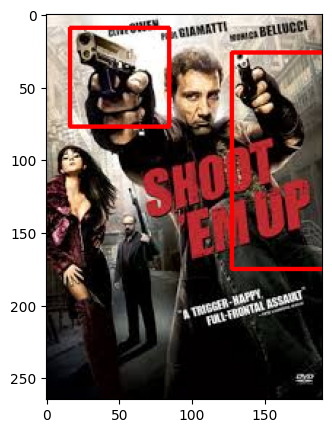

In [75]:
plot_img_bbox(torch_to_pil(img),target)

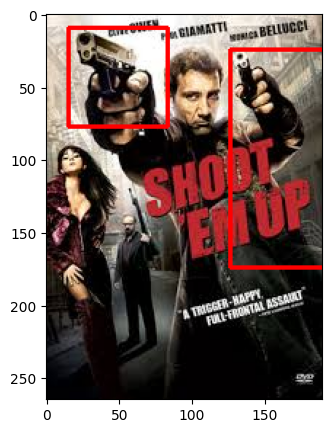

In [76]:
plot_img_bbox(torch_to_pil(img),nms_prediction)